# Homework 1 (Due Sep 23, 2025 by Noon) 


## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

You've learned how to create L- and M- estimators and use them to estimate the parameters of a model. Generally, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$
You can use one of the estimators we discussed in the lecture, but you should be aware that the dataset can have outliers. 


Once you write down the $\ln L$ in terms of the model parameters, $a$ and $b$, this is the expression that you now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements your favorite robust loss function, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fmin
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
# %config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [3]:
# Make squared loss with uncertainties = chi2
def model(x, a, b):
    return a*x + b

def chi2(a, b, x, y, dy):
    y_model = model(x, a, b)
    resid = y - y_model
    chi2 = np.sum((resid/dy)**2)
    return chi2

# Log-likelihood function:
# ln L = ln [product of all probability]
# Use NLL to minimize instead of maximize
def NLL(a, b, x, y, dy):
    chisq = chi2(a, b, x, y, dy)
    logL = -0.5 * (chisq + np.sum(np.log(2*np.pi*dy**2)))
    return -logL

In [4]:
# Guess initial
a_guess, b_guess = np.polyfit(x, y, 1)

# Make grid of a and b
a_grid = np.linspace(a_guess - 5, a_guess + 5, 2000)
b_grid = np.linspace(b_guess - 250, b_guess + 250, 2000)

AA, BB = np.meshgrid(a_grid, b_grid)

NLL_grid = np.empty_like(AA)
# Use the likelihood, NLL
for i in range(BB.shape[0]):
    for j in range(AA.shape[1]):
        NLL_grid[i, j] = NLL(AA[i, j], BB[i, j], x, y, dy)

# find minimum
x_min, y_min = np.unravel_index(np.argmin(NLL_grid), NLL_grid.shape)
a_MLE, b_MLE = AA[x_min, y_min], BB[x_min, y_min]
print(a_MLE, b_MLE)

1.0747328966084275 213.59399094824894


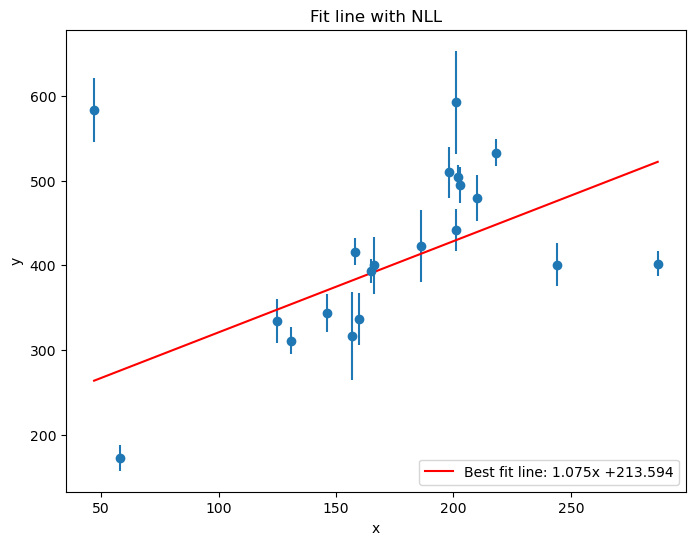

In [5]:
# Plot fit line
x_line = np.linspace(np.min(x), np.max(x), 200)
y_line = model(x_line, a_MLE, b_MLE)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=dy, fmt='o')
plt.plot(x_line, y_line, 'r', label=f'Best fit line: {a_MLE:.3f}x +{b_MLE:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.title('Fit line with NLL')
plt.show()

In [6]:
from astropy.stats import sigma_clip
# Sigma clipping for those above 2 sigma
# Everything is included in 3 sigma-level for some reason
norm_resid = (y - model(x, a_MLE, b_MLE))/dy
mask = ~sigma_clip(norm_resid, sigma=2, maxiters=5).mask

x_new = x[mask]
y_new = y[mask]
dy_new = dy[mask]

# Re-fit with the "new" dataset with outliers rejected
# Guess initial
a_guess, b_guess = np.polyfit(x_new, y_new, 1)

# Make grid of a and b
a_grid = np.linspace(a_guess - 5, a_guess + 5, 1000)
b_grid = np.linspace(b_guess - 250, b_guess + 250, 1000)

AA, BB = np.meshgrid(a_grid, b_grid)

NLL_grid = np.empty_like(AA)
# Use the likelihood, NLL
for i in range(BB.shape[0]):
    for j in range(AA.shape[1]):
        NLL_grid[i, j] = NLL(AA[i, j], BB[i, j], x_new, y_new, dy_new)

# find minimum
x_min, y_min = np.unravel_index(np.argmin(NLL_grid), NLL_grid.shape)
a_clip, b_clip = AA[x_min, y_min], BB[x_min, y_min]
print(a_clip, b_clip)

1.475699081998782 147.9108983575311


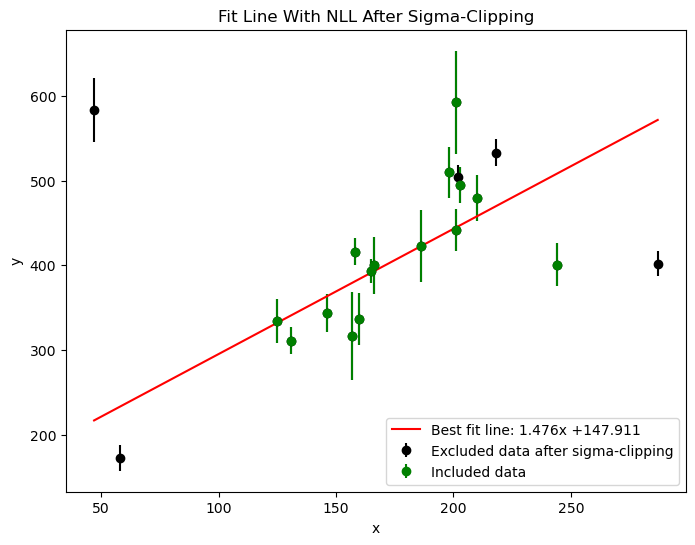

In [7]:
# Plot fit line
x_line = np.linspace(np.min(x), np.max(x), 200)
y_line = model(x_line, a_clip, b_clip)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=dy, fmt='o', color='black', label='Excluded data after sigma-clipping')
plt.errorbar(x_new, y_new, yerr=dy_new, fmt='o', color='green', label='Included data')
plt.plot(x_line, y_line, 'r', label=f'Best fit line: {a_clip:.3f}x +{b_clip:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.title('Fit Line With NLL After Sigma-Clipping')
plt.show()

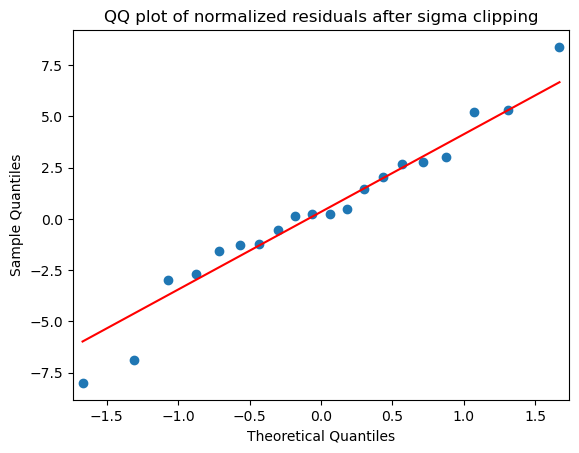

In [8]:
# Plot QQplot
sm.qqplot(norm_resid, line="s")
plt.title("QQ plot of normalized residuals after sigma clipping")
plt.show()

In [9]:
# Let's make new likelihood function with huber loss
def huber_loss(params, x, y, dy, delta):
    a, b = params
    norm_resid = (y-model(x, a, b))/dy
    quad = 0.5 * norm_resid**2 # quadratic for <= delta
    lin = delta * (np.abs(norm_resid) - 0.5 * delta) # linear for > delta
    loss = np.where(np.abs(norm_resid) <= delta, quad, lin)
    return np.sum(loss)

# Fit with fmin, use delta=1.345 (I ask ChatGPT for a good value)
minimize = fmin(huber_loss, [a_guess, b_guess], args=(x, y, dy, 1.345))
a_huber, b_huber = minimize
print(a_huber, b_huber)

Optimization terminated successfully.
         Current function value: 55.244166
         Iterations: 49
         Function evaluations: 92
1.950253907654141 74.29296405822456


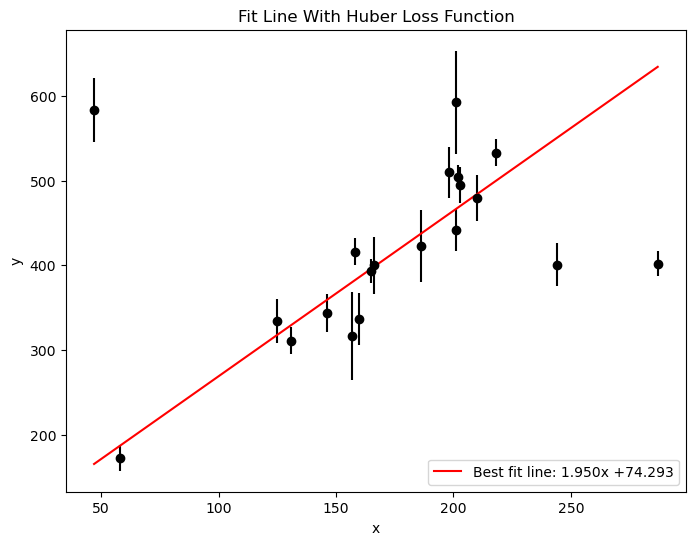

In [10]:
# Plot fit line
x_line = np.linspace(np.min(x), np.max(x), 200)
y_line = model(x_line, a_huber, b_huber)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=dy, fmt='o', color='black')
plt.plot(x_line, y_line, 'r', label=f'Best fit line: {a_huber:.3f}x +{b_huber:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.title('Fit Line With Huber Loss Function')
plt.show()

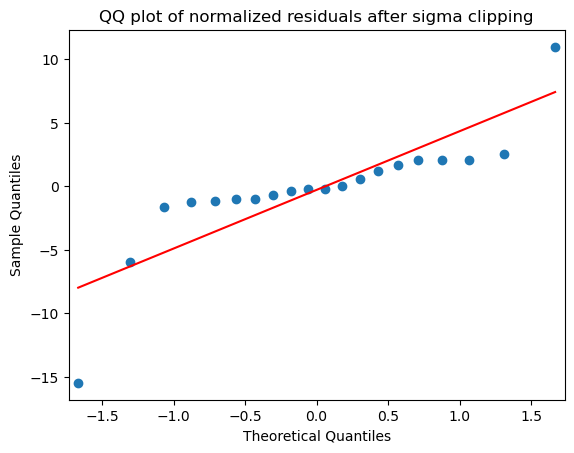

In [11]:
# Plot QQplot
norm_resid = (y - model(x, a_huber, b_huber))/dy
sm.qqplot(norm_resid, line="s")
plt.title("QQ plot of normalized residuals after sigma clipping")
plt.show()

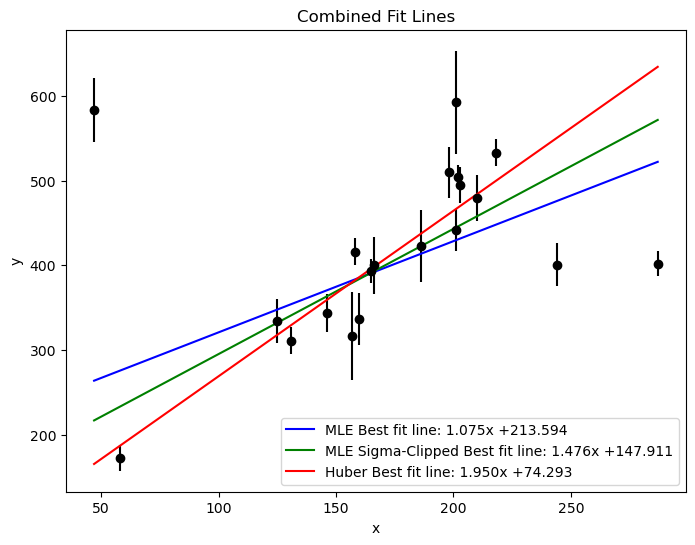

In [12]:
# Combine all plots
x_line = np.linspace(np.min(x), np.max(x), 200)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=dy, fmt='o', color='black')
plt.plot(x_line, model(x_line, a_MLE, b_MLE), 'b', label=f'MLE Best fit line: {a_MLE:.3f}x +{b_MLE:.3f}')
plt.plot(x_line, model(x_line, a_clip, b_clip), 'g', label=f'MLE Sigma-Clipped Best fit line: {a_clip:.3f}x +{b_clip:.3f}')
plt.plot(x_line, model(x_line, a_huber, b_huber), 'r', label=f'Huber Best fit line: {a_huber:.3f}x +{b_huber:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.title('Combined Fit Lines')
plt.show()

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [13]:
import pandas as pd
df = pd.read_csv('../01/Cepheids.csv')
df

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


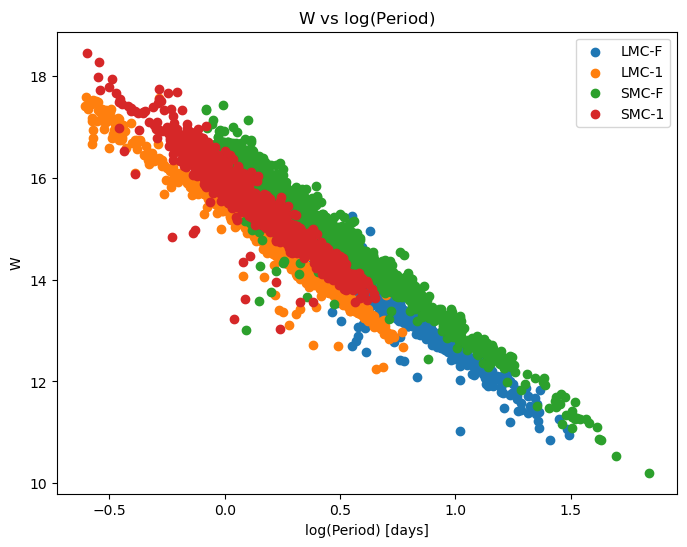

In [14]:
# Split into LMC SMC
df_LMC = df[df['Cloud'] == 'LMC']
df_SMC = df[df['Cloud'] == 'SMC']

# Split into mode F and 1
df_LMC_F = df_LMC[df_LMC['Mode'] == 'F']
df_LMC_1 = df_LMC[df_LMC['Mode'] == '1']

df_SMC_F = df_SMC[df_SMC['Mode'] == 'F']
df_SMC_1 = df_SMC[df_SMC['Mode'] == '1']

plt.figure(figsize=(8,6))
plt.scatter(df_LMC_F['logP1'], df_LMC_F['W'], label="LMC-F")
plt.scatter(df_LMC_1['logP1'], df_LMC_1['W'], label="LMC-1")
plt.scatter(df_SMC_F['logP1'], df_SMC_F['W'], label="SMC-F")
plt.scatter(df_SMC_1['logP1'], df_SMC_1['W'], label="SMC-1")
plt.xlabel("log(Period) [days]")
plt.ylabel("W")
plt.title(r"W vs $\log(\rm Period)$")
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 18.667597
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 14.199501
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 58.201275
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 40.336377
         Iterations: 29
         Function evaluations: 57


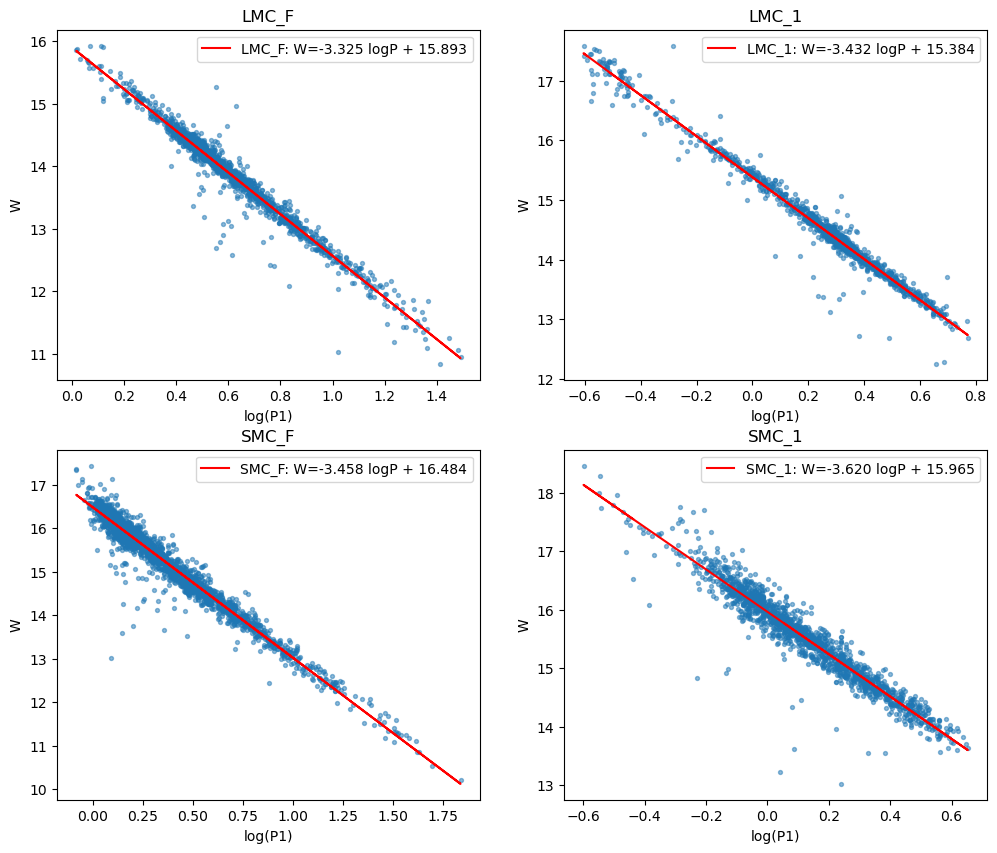

In [15]:
# Fit line
a_guess, b_guess = np.polyfit(df['logP1'], df['W'], 1)
a_LMC_F, b_LMC_F = fmin(huber_loss, [a_guess, b_guess], args=(df_LMC_F['logP1'], df_LMC_F['W'], 1, 1.345))
a_LMC_1, b_LMC_1 = fmin(huber_loss, [a_guess, b_guess], args=(df_LMC_1['logP1'], df_LMC_1['W'], 1, 1.345))
a_SMC_F, b_SMC_F = fmin(huber_loss, [a_guess, b_guess], args=(df_SMC_F['logP1'], df_SMC_F['W'], 1, 1.345))
a_SMC_1, b_SMC_1 = fmin(huber_loss, [a_guess, b_guess], args=(df_SMC_1['logP1'], df_SMC_1['W'], 1, 1.345))

# Plot all four samples with the fitted lines
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
x = df_LMC_F['logP1'].values
y = df_LMC_F['W'].values
ax1.scatter(x, y, s=8, alpha=0.5)
ax1.plot(x, a_LMC_F * x + b_LMC_F, 'r-', label=f"LMC_F: W={a_LMC_F:.3f} logP + {b_LMC_F:.3f}")
ax1.set_title("LMC_F")
ax1.set_xlabel("log(P1)")
ax1.set_ylabel("W")
ax1.legend()

ax2 = axes[0, 1]
x = df_LMC_1['logP1'].values
y = df_LMC_1['W'].values
ax2.scatter(x, y, s=8, alpha=0.5)
ax2.plot(x, a_LMC_1 * x + b_LMC_1, 'r-', label=f"LMC_1: W={a_LMC_1:.3f} logP + {b_LMC_1:.3f}")
ax2.set_title("LMC_1")
ax2.set_xlabel("log(P1)")
ax2.set_ylabel("W")
ax2.legend()

ax3 = axes[1, 0]
x = df_SMC_F['logP1'].values
y = df_SMC_F['W'].values
ax3.scatter(x, y, s=8, alpha=0.5)
ax3.plot(x, a_SMC_F * x + b_SMC_F, 'r-', label=f"SMC_F: W={a_SMC_F:.3f} logP + {b_SMC_F:.3f}")
ax3.set_title("SMC_F")
ax3.set_xlabel("log(P1)")
ax3.set_ylabel("W")
ax3.legend()

ax4 = axes[1, 1]
x = df_SMC_1['logP1'].values
y = df_SMC_1['W'].values
ax4.scatter(x, y, s=8, alpha=0.5)
ax4.plot(x, a_SMC_1 * x + b_SMC_1, 'r-', label=f"SMC_1: W={a_SMC_1:.3f} logP + {b_SMC_1:.3f}")
ax4.set_title("SMC_1")
ax4.set_xlabel("log(P1)")
ax4.set_ylabel("W")
ax4.legend()
plt.show()


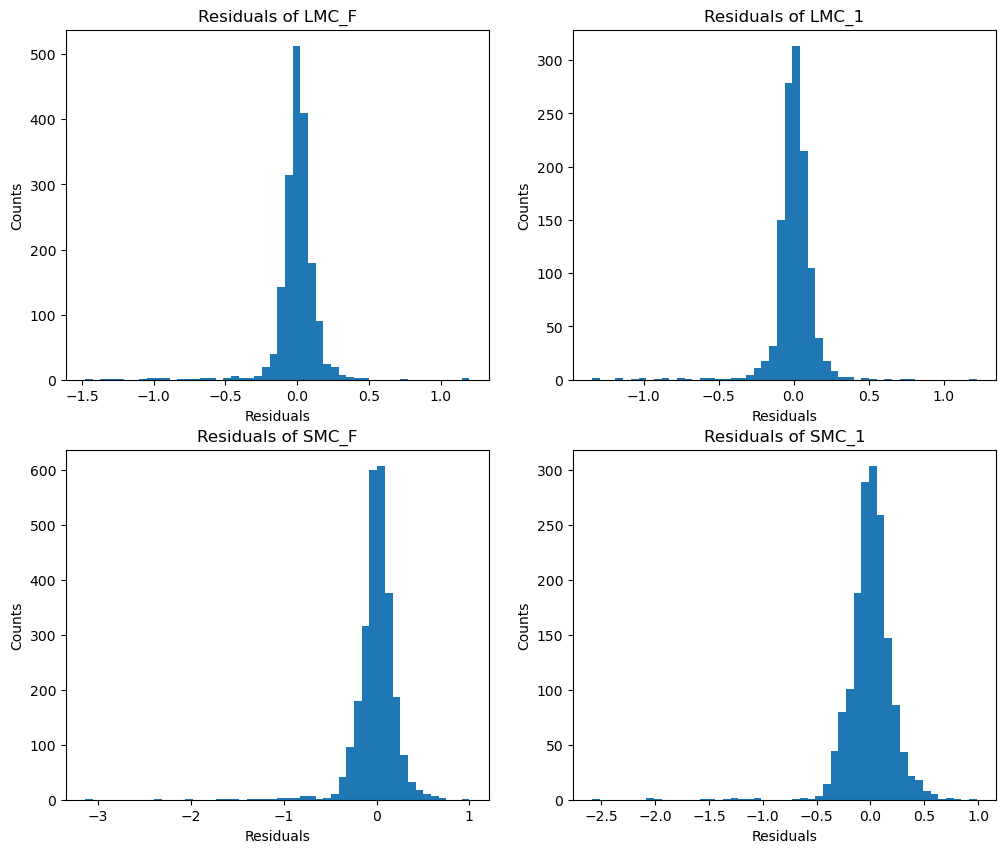

In [16]:
# Plot all four samples residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
x = df_LMC_F['logP1'].values
y = df_LMC_F['W'].values
resid_LMC_F = y - (a_LMC_F * x + b_LMC_F)
ax1.hist(resid_LMC_F, bins=50)
ax1.set_title("Residuals of LMC_F")
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Counts")

ax2 = axes[0, 1]
x = df_LMC_1['logP1'].values
y = df_LMC_1['W'].values
resid_LMC_1 = y - (a_LMC_1 * x + b_LMC_1)
ax2.hist(y - (a_LMC_1 * x + b_LMC_1), bins=50)
ax2.set_title("Residuals of LMC_1")
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Counts")

ax3 = axes[1, 0]
x = df_SMC_F['logP1'].values
y = df_SMC_F['W'].values
resid_SMC_F = y - (a_SMC_F * x + b_SMC_F)
ax3.hist(resid_SMC_F, bins=50)
ax3.set_title("Residuals of SMC_F")
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Counts")

ax4 = axes[1, 1]
x = df_SMC_1['logP1'].values
y = df_SMC_1['W'].values
resid_SMC_1 = y - (a_SMC_1 * x + b_SMC_1)
ax4.hist(resid_SMC_1, bins=50)
ax4.set_title("Residuals of SMC_1")
ax4.set_xlabel("Residuals")
ax4.set_ylabel("Counts")
plt.show()

The residuals are approximately gaussian, centered at 0. Although some may have some skewing to the negative direction (like residuals of `SMC_F` and `SMC_1`).

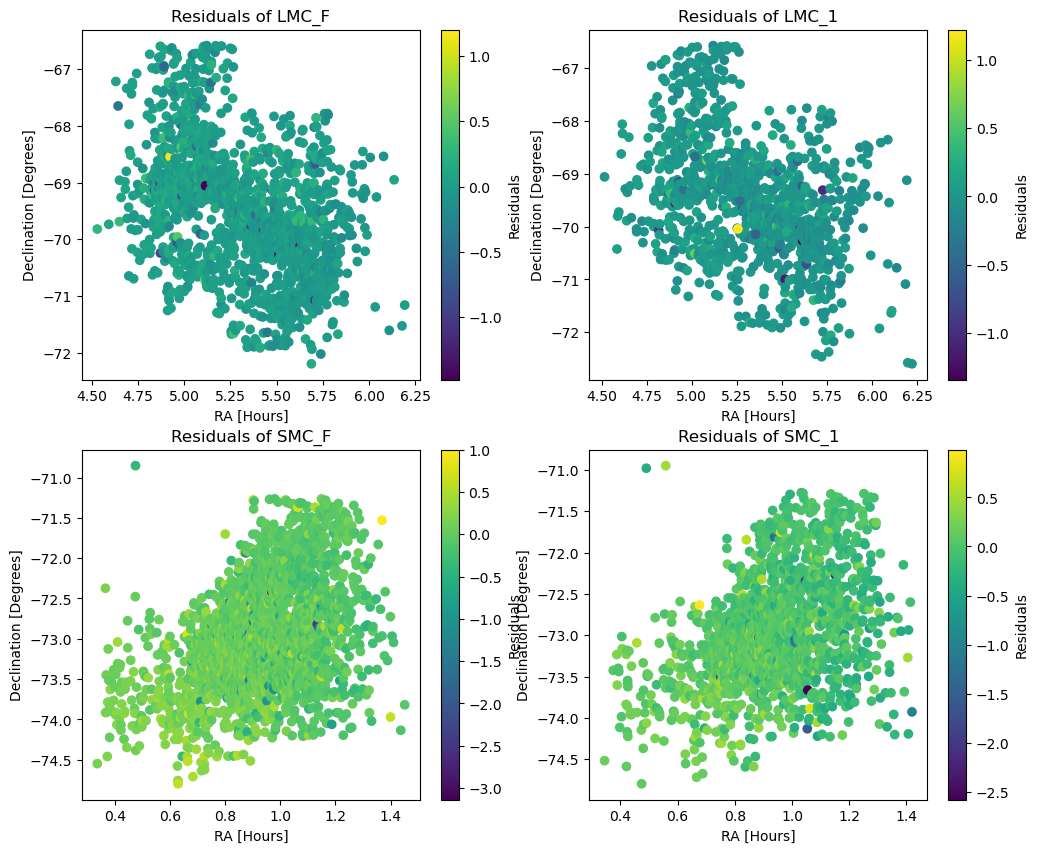

In [17]:
# Plot residuals with RA Dec

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
plot_res = ax1.scatter(df_LMC_F['RA0'], df_LMC_F['Decl0'], c=resid_LMC_F, cmap='viridis')
plt.colorbar(plot_res, label='Residuals')
ax1.set_title("Residuals of LMC_F")
ax1.set_xlabel("RA [Hours]")
ax1.set_ylabel("Declination [Degrees]")

ax2 = axes[0, 1]
plot_res = ax2.scatter(df_LMC_1['RA0'], df_LMC_1['Decl0'], c=resid_LMC_1, cmap='viridis')
plt.colorbar(plot_res, label='Residuals')
ax2.set_title("Residuals of LMC_1")
ax2.set_xlabel("RA [Hours]")
ax2.set_ylabel("Declination [Degrees]")

ax3 = axes[1, 0]
plot_res = ax3.scatter(df_SMC_F['RA0'], df_SMC_F['Decl0'], c=resid_SMC_F, cmap='viridis')
plt.colorbar(plot_res, label='Residuals')
ax3.set_title("Residuals of SMC_F")
ax3.set_xlabel("RA [Hours]")
ax3.set_ylabel("Declination [Degrees]")

ax4 = axes[1, 1]
plot_res = ax4.scatter(df_SMC_1['RA0'], df_SMC_1['Decl0'], c=resid_SMC_1, cmap='viridis')
plt.colorbar(plot_res, label='Residuals')
ax4.set_title("Residuals of SMC_1")
ax4.set_xlabel("RA [Hours]")
ax4.set_ylabel("Declination [Degrees]")
plt.show()

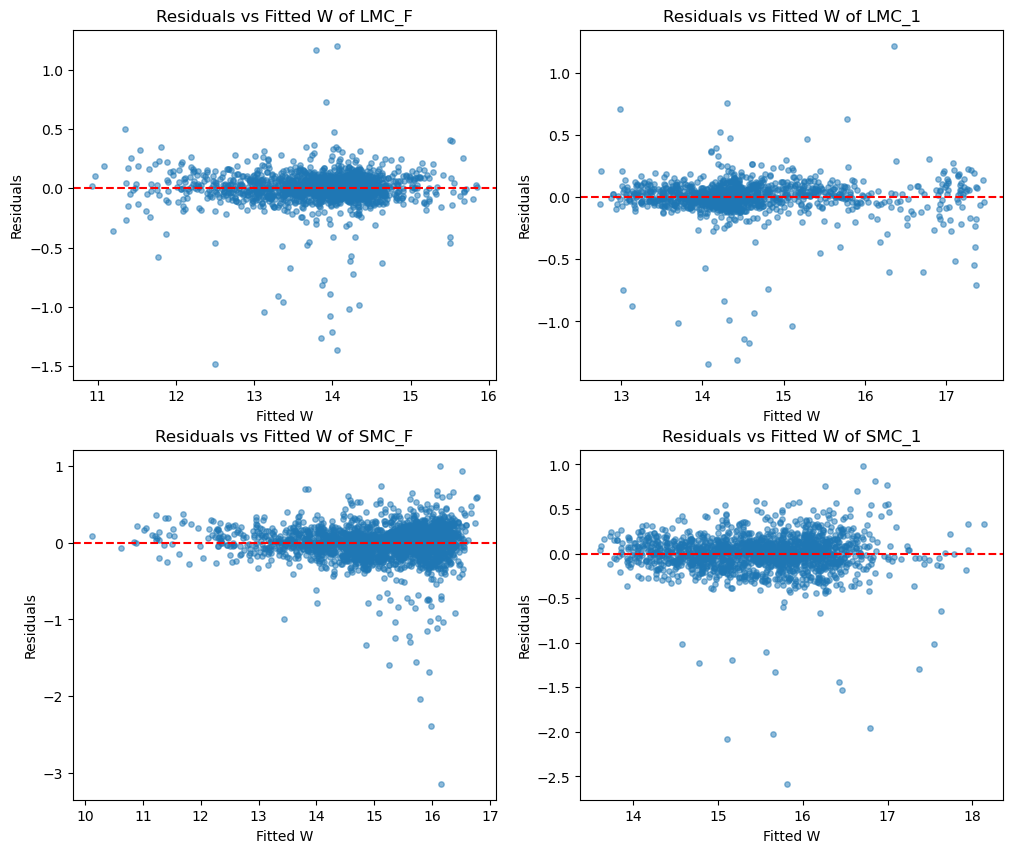

In [18]:
# Plot residuals vs fitted W
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
ax1.scatter(a_LMC_F * df_LMC_F['logP1'] + b_LMC_F, resid_LMC_F, s=15, alpha=0.5)
ax1.axhline(0, color='red', ls='--')
ax1.set_title("Residuals vs Fitted W of LMC_F")
ax1.set_xlabel("Fitted W")
ax1.set_ylabel("Residuals")

ax2 = axes[0, 1]
ax2.scatter(a_LMC_1 * df_LMC_1['logP1'] + b_LMC_1, resid_LMC_1, s=15, alpha=0.5)
ax2.axhline(0, color='red', ls='--')
ax2.set_title("Residuals vs Fitted W of LMC_1")
ax2.set_xlabel("Fitted W")
ax2.set_ylabel("Residuals")

ax3 = axes[1, 0]
ax3.scatter(a_SMC_F * df_SMC_F['logP1'] + b_SMC_F, resid_SMC_F, s=15, alpha=0.5)
ax3.axhline(0, color='red', ls='--')
ax3.set_title("Residuals vs Fitted W of SMC_F")
ax3.set_xlabel("Fitted W")
ax3.set_ylabel("Residuals")

ax4 = axes[1, 1]
ax4.scatter(a_SMC_1 * df_SMC_1['logP1'] + b_SMC_1, resid_SMC_1, s=15, alpha=0.5)
ax4.axhline(0, color='red', ls='--')
ax4.set_title("Residuals vs Fitted W of SMC_1")
ax4.set_xlabel("Fitted W")
ax4.set_ylabel("Residuals")
plt.show()

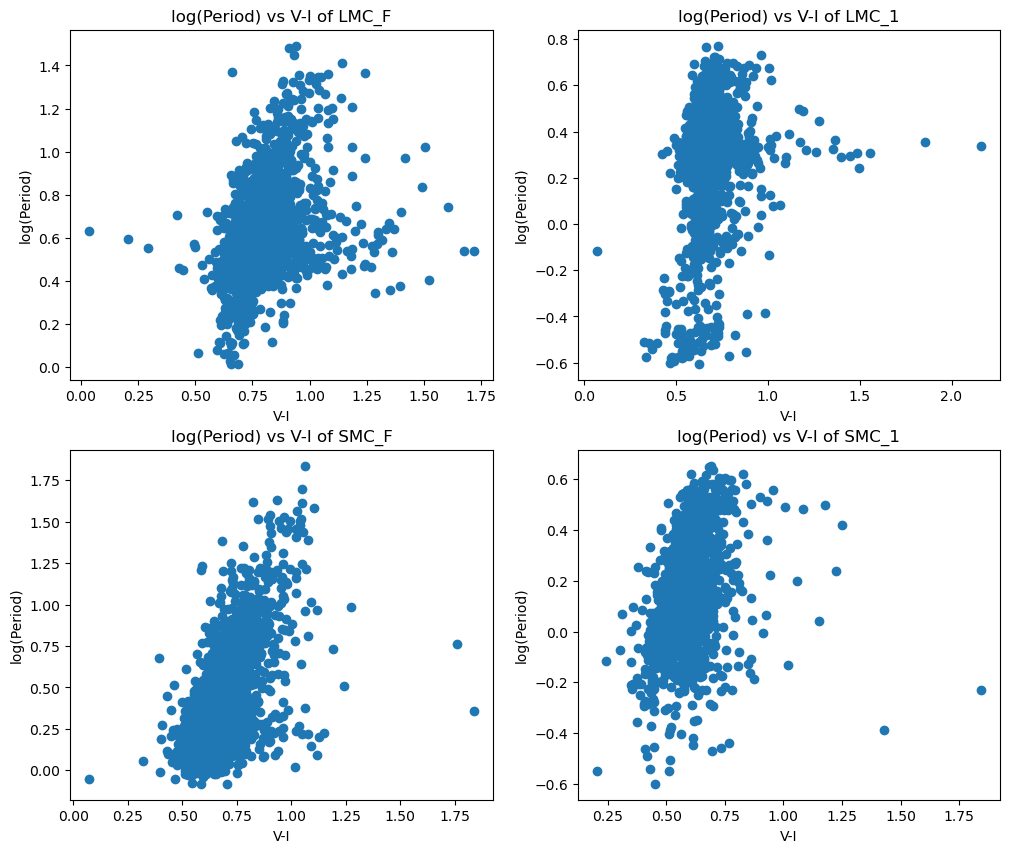

In [19]:
# Plot log(P1) vs V-I
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
ax1.scatter(df_LMC_F['VI'], df_LMC_F['logP1'])
ax1.set_title("log(Period) vs V-I of LMC_F")
ax1.set_xlabel("V-I")
ax1.set_ylabel("log(Period)")

ax2 = axes[0, 1]
ax2.scatter(df_LMC_1['VI'], df_LMC_1['logP1'])
ax2.set_title("log(Period) vs V-I of LMC_1")
ax2.set_xlabel("V-I")
ax2.set_ylabel("log(Period)")

ax3 = axes[1, 0]
ax3.scatter(df_SMC_F['VI'], df_SMC_F['logP1'])
ax3.set_title("log(Period) vs V-I of SMC_F")
ax3.set_xlabel("V-I")
ax3.set_ylabel("log(Period)")

ax4 = axes[1, 1]
ax4.scatter(df_SMC_1['VI'], df_SMC_1['logP1'])
ax4.set_title("log(Period) vs V-I of SMC_1")
ax4.set_xlabel("V-I")
ax4.set_ylabel("log(Period)")
plt.show()

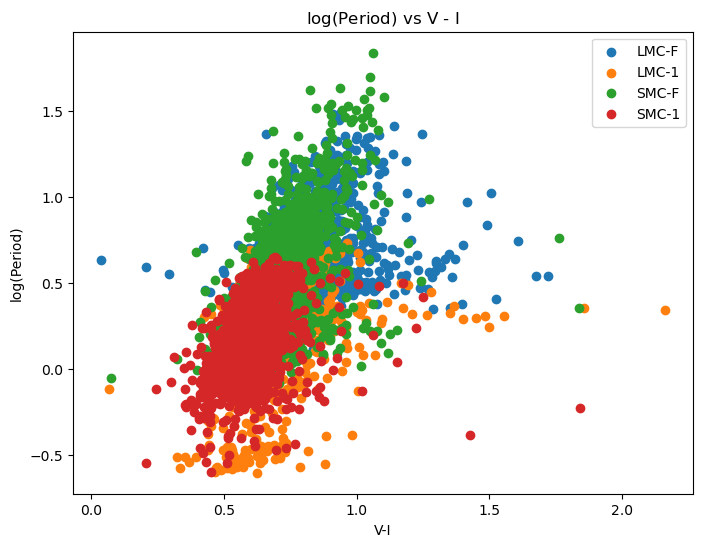

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df_LMC_F['VI'], df_LMC_F['logP1'], label="LMC-F")
plt.scatter(df_LMC_1['VI'], df_LMC_1['logP1'], label="LMC-1")
plt.scatter(df_SMC_F['VI'], df_SMC_F['logP1'], label="SMC-F")
plt.scatter(df_SMC_1['VI'], df_SMC_1['logP1'], label="SMC-1")
plt.xlabel("V-I")
plt.ylabel("log(Period)")
plt.title(r"$\log(\rm Period)$ vs V - I")
plt.legend()
plt.show()

A general trend that I found is that first-overtone stars typically have shorter periods while the fundamental-mode have longer periods in both LMC and SMC.